In [1]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd #data processing

import os
import re
import nltk

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
print(train.shape, test.shape)

(20800, 5) (5200, 4)


In [4]:
print(train.isnull().sum())
print('************')
print(test.isnull().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64
************
id          0
title     122
author    503
text        7
dtype: int64


In [5]:
test=test.fillna(' ')
train=train.fillna(' ')
test['total']=test['title']+' '+test['author']+test['text']
train['total']=train['title']+' '+train['author']+train['text']

# Creating Wordcloud Visuals

In [6]:
real_words = ''
fake_words = ''
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train[train['label']==1].total: 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    real_words += " ".join(tokens)+" "

for val in train[train['label']==0].total: 
      
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    fake_words += " ".join(tokens)+" "

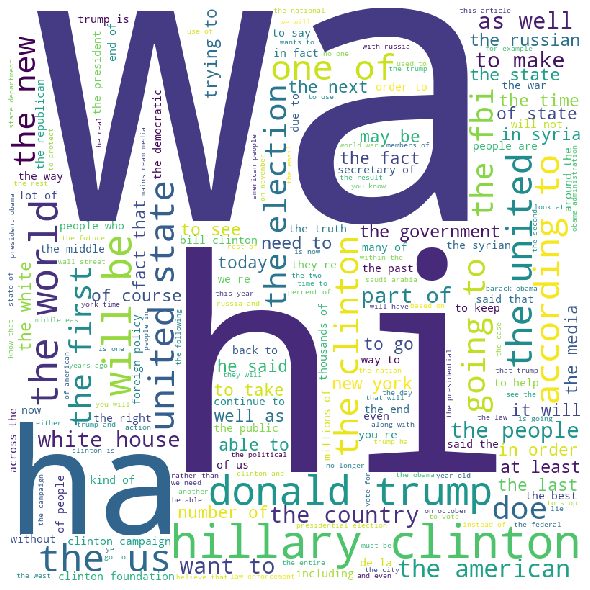

In [7]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(real_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [9]:
#Downloading nltk data
nltk.download('punkt')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

#Cleaning and pre-processing
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
for index,row in train.iterrows():
    filter_sentence = ''
    
    sentence = row['total']
    sentence = re.sub(r'[^\w\s]','',sentence) #cleaning
    
    words = nltk.word_tokenize(sentence) #tokenization
    
    words = [w for w in words if not w in stop_words]  #stopwords removal
    
    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
        
    train.loc[index,'total'] = filter_sentence


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [10]:
train = train[['total','label']]

# Applying NLP Techniques

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
X_train = train['total']
Y_train = train['label']

In [33]:
#Feature extraction using count vectorization and tfidf.
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_train)
freq_term_matrix = count_vectorizer.transform(X_train)
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [34]:
tf_idf_matrix

<20800x220387 sparse matrix of type '<class 'numpy.float64'>'
	with 5987666 stored elements in Compressed Sparse Row format>

# Confusion Matrix

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in iter.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Modelling

In [21]:
test_counts = count_vectorizer.transform(test['total'].values)
test_tfidf = tfidf.transform(test_counts)

#split in samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train, random_state=0)

# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
from sklearn.naive_bayes import MultinomialNB
cm = confusion_matrix(y_test, pred)
cm

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Lasso classifier on training set: 1.00
Accuracy of Lasso classifier on test set: 0.98


array([[2494,   70],
       [  45, 2591]], dtype=int64)

# MultinomialNB

In [23]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
pred = NB.predict(X_test)
print('Accuracy of NB  classifier on training set: {:.2f}'
     .format(NB.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))
cm = confusion_matrix(y_test, pred)
cm

Accuracy of NB  classifier on training set: 0.88
Accuracy of NB classifier on test set: 0.83


array([[2558,    6],
       [ 853, 1783]], dtype=int64)

# Pipeline

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn import linear_model

In [40]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', linear_model.LogisticRegression(C=1e5)),
])

In [41]:
pipeline.fit(X_train, Y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [42]:
pipeline.predict(["flynn hillary clinton big woman campus breitbart daniel j flynnever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed 48 year ago first addressed wellesley graduating class the president college informed gathered 1969 student needed debate far i could ascertain spokesman kind like democratic primary 2016 minus term unknown even seven sisters school i glad miss adams made clear i speaking today u 400 u miss rodham told classmate after appointing edger bergen charlie mccarthys mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u s senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clinton senior thesis saul alinsky lamented black power demagogue elitist arrogance repressive intolerance within new left similar word coming republican necessitated brief rebuttal trust rodham ironically observed 1969 one word i asked class rehearsal wanted say everyone came said talk trust talk lack trust u way feel others talk trust bust what say what say feeling permeates generation perhaps even understood distrusted the trust bust certainly busted clintons 2016 plan she certainly even understand people distrusted after whitewater travelgate vast conspiracy benghazi missing email clinton found distrusted voice friday there load compromising road broadening political horizon and distrust american people trump edged 48 percent 38 percent question immediately prior novembers election stood major reason closing horizon clinton described vanquisher supporter embracing lie con alternative fact assault truth reason she failed explain american people chose lie truth as history major among today know well people power invent fact attack question mark beginning end free society offered that hyperbole like many people emerge 1960s hillary clinton embarked upon long strange trip from high school goldwater girl wellesley college republican president democratic politician clinton drank time place gave degree more significantly went idealist cynic comparison two wellesley commencement address show way back lamented long leader viewed politics art possible challenge practice politics art making appears impossible possible now big woman campus odd woman white house wonder current station even possible why arent i 50 point ahead asked september in may asks isnt president the woman famously dubbed congenital liar bill safire concludes lie mind getting stood election day like finding jilted bride wedding day inspires dangerous delusion"])

array([0], dtype=int64)

In [43]:
#saving the pipeline
filename = 'pipeline.sav'
joblib.dump(pipeline, filename)

['pipeline.sav']

In [44]:
filename = './pipeline.sav'

# Prediction

In [49]:
loaded_model = joblib.load(filename)
result = loaded_model.predict(["flynn hillary clinton big woman campus breitbart daniel j flynnever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed 48 year ago first addressed wellesley graduating class the president college informed gathered 1969 student needed debate far i could ascertain spokesman kind like democratic primary 2016 minus term unknown even seven sisters school i glad miss adams made clear i speaking today u 400 u miss rodham told classmate after appointing edger bergen charlie mccarthys mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u s senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clinton senior thesis saul alinsky lamented black power demagogue elitist arrogance repressive intolerance within new left similar word coming republican necessitated brief rebuttal trust rodham ironically observed 1969 one word i asked class rehearsal wanted say everyone came said talk trust talk lack trust u way feel others talk trust bust what say what say feeling permeates generation perhaps even understood distrusted the trust bust certainly busted clintons 2016 plan she certainly even understand people distrusted after whitewater travelgate vast conspiracy benghazi missing email clinton found distrusted voice friday there load compromising road broadening political horizon and distrust american people trump edged 48 percent 38 percent question immediately prior novembers election stood major reason closing horizon clinton described vanquisher supporter embracing lie con alternative fact assault truth reason she failed explain american people chose lie truth as history major among today know well people power invent fact attack question mark beginning end free society offered that hyperbole like many people emerge 1960s hillary clinton embarked upon long strange trip from high school goldwater girl wellesley college republican president democratic politician clinton drank time place gave degree more significantly went idealist cynic comparison two wellesley commencement address show way back lamented long leader viewed politics art possible challenge practice politics art making appears impossible possible now big woman campus odd woman white house wonder current station even possible why arent i 50 point ahead asked september in may asks isnt president the woman famously dubbed congenital liar bill safire concludes lie mind getting stood election day like finding jilted bride wedding day inspires dangerous delusion"])

if result == 0 :
    print("Fake News!!!")
else :
    print("Real News!!!")

Fake News!!!
